# Extract annotation information from Metabolic Atlas via Human-GEM

Note: Requires internet connection to retrieve latest files from the [MetabolicAtlas Human-GEM repository](https://github.com/SysBioChalmers/Human-GEM).

## Setup
### Import packages

In [1]:
import pandas as pd
from warnings import warn

from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ROOT_PATH,
    DATABASE_PATH,
    INTERIM_PATH,
    ANNOTATION_PATH,
    read_cobra_model,
    read_rbc_model,
    show_versions,
    get_annotation_df,
    compare_tables,
    visualize_comparison,
    build_string,
    split_string,
)

from rbc_gem_utils.database.metatlas import (
    HUMANGEM_MIRIAM,
    HUMANGEM_PATH,
    HUMANGEM_VERSION_EXPECTED,
    HUMANGEM_DB_TAG,
    download_database_HumanGEM,
    get_version_HumanGEM,
    get_annotations_HumanGEM,
)

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,glpk
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Check Human-GEM version
If the Human-GEM version does not match the expected version, it is because Human-GEM has been updated since the last time this code was utilized. 
### Expected HumanGEM version: 1.18.0

In [3]:
version = get_version_HumanGEM(f"v{HUMANGEM_VERSION_EXPECTED}")
try:
    assert (
        HUMANGEM_VERSION_EXPECTED == version
    ), "Expected and retrieved versions are not the same"
except AssertionError as e:
    warn("Expected and retrieved versions are not the same")
    print(f"Expected Human-GEM version: {HUMANGEM_VERSION_EXPECTED}")
    print(f"Retrieved Human-GEM version {version}.")
else:
    print("Retrieved version matches expected version.")

Retrieved version matches expected version.


#### Download new files and update database
If an argument is not provided (`arg=None`), its default value for the repository used. 

In [4]:
# Download data into interim directory
download = False
database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"
annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
if download:
    download_database_HumanGEM(
        annotation_type={"metabolites", "reactions", "genes"},
        database_dirpath=f"{database_dirpath}/{HUMANGEM_PATH}",
        model_filetype={"xml", "yml"},
        model_version=version,
    )

## Load RBC-GEM model

In [5]:
model = read_rbc_model(filetype="xml")
model.reactions.sort()
model.genes.sort()
model.metabolites.sort()
model

Name,RBC_GEM
Memory address,145d95350
Number of metabolites,2008
Number of reactions,2977
Number of genes,718
Number of groups,77
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [6]:
compare = True
display_nunique = True
overwrite = True

## Reactions

* `reactions.tsv` content:

|# |fieldname      |annotation               |Prefixes (https://identifiers.org/)|
|--|---------------|-------------------------|-----------------------------------|
|1 |rxns           |identical to `model.rxns`|metatlas                           |
|2 |rxnKEGGID      |KEGG reaction ID         |kegg.reaction                      |
|3 |rxnBiGGID      |BiGG reaction ID         |bigg.reaction                      |
|4 |rxnEHMNID      |EHMN reaction ID         |                                   |
|5 |rxnHepatoNET1ID|HepatoNET1 reaction ID   |                                   |
|6 |rxnREACTOMEID  |REACTOME ID              |reactome                           |
|7 |rxnRecon3DID   |Recon3D reaction ID      |vmhreaction                        |
|8 |rxnMetaNetXID  |MetaNetX reaction ID     |metanetx.reaction                  |
|9 |rxnHMR2ID      |HMR2 reaction ID         |                                   |
|10|rxnRatconID    |Ratcon reaction ID       |                                   |
|11|rxnTCDBID      |TCDB ID                  |tcdb                               |
|12|spontaneous    |Spontaneous status       |                                   |
|13|rxnRheaID      |Rhea ID                  |rhea                               |
|14|rxnRheaMasterID|Master Rhea ID           |rhea                               |
|15|rxnRetired     |Retired reaction IDs     |                                   |

##### Notes

* `spontaneous` status column is included.
* Otherwise, include columns that link to https://identifiers.org/.
* For `rhea`:
    * The master Rhea ID is utilized for the annotation.
    * The "RHEA:" prefix from Rhea IDs needs to be stripped.
* `ec-code` annotations are currently stored in the model file.

In [7]:
HumanGEM = read_cobra_model(f"{database_dirpath}{HUMANGEM_PATH}/Human-GEM.xml")
HumanGEM

Name,HumanGEM
Memory address,147913810
Number of metabolites,8456
Number of reactions,12995
Number of genes,2889
Number of groups,148
Objective expression,1.0*MAR13082 - 1.0*MAR13082_reverse_11d67
Compartments,"Cytosol, Extracellular, Lysosome, Endoplasmic reticulum, Mitochondria, Peroxisome, Golgi apparatus, Nucleus, Inner mitochondria"


In [8]:
annotation_type = "reactions"
mapping_key = "metatlas"
merge_key = "rxnMetAtlas"
rename_miriam = True
annotation_columns = HUMANGEM_MIRIAM[annotation_type].copy()

del annotation_columns["rxnRheaID"]
annotation_columns = list(annotation_columns) + ["spontaneous", "ec-code"]

reactions            2977
metatlas             1538
kegg.reaction         505
bigg.reaction         815
reactome               14
vmhreaction          1567
metanetx.reaction    1110
tcdb                   31
rhea                  432
spontaneous             2
ec-code               378
dtype: int64


,reactions,metatlas,kegg.reaction,bigg.reaction,reactome,vmhreaction,metanetx.reaction,tcdb,rhea,spontaneous,ec-code
0,13DAMPPOX,MAR07992,NaN,13DAMPPOX,NaN,13DAMPPOX,MNXR94687,NaN,NaN,0,1.4.3.6;1.4.3.21;1.4.3.22
1,15KPGE1Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15KPGE2Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15KPGE3Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15KPGF1Ry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2972,YYYTPAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2973,ZN2Htex2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2974,ZN2_2HCO3t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2975,ZN2_HCO3_SELNIt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


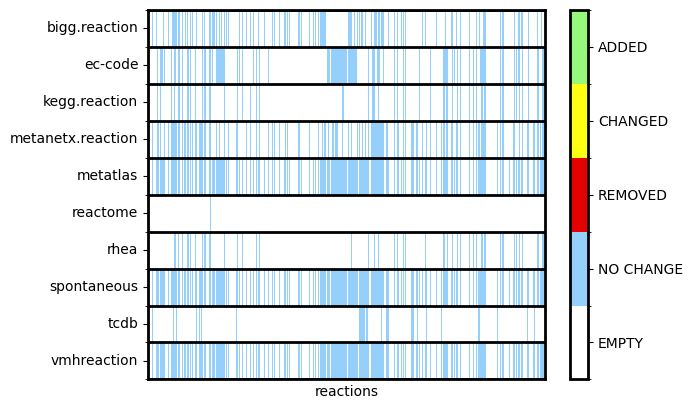

In [9]:
df_model = get_annotation_df(getattr(model, annotation_type), [mapping_key]).rename(
    {"id": annotation_type}, axis=1
)

df_annotations = get_annotations_HumanGEM(
    annotation_type, f"{database_dirpath}{HUMANGEM_PATH}"
)
df_annotations = df_annotations.rename({"rxns": merge_key}, axis=1)
df_annotations = df_annotations.merge(
    pd.DataFrame.from_dict(
        {
            rxn.id: build_string(rxn.annotation.get("ec-code", []))
            for rxn in HumanGEM.reactions
            if rxn.annotation.get("ec-code", [])
        },
        orient="index",
        columns=["ec-code"],
    ),
    left_on=merge_key,
    right_index=True,
    how="left",
)

df_annotations = df_model.merge(
    df_annotations,
    left_on=mapping_key,
    right_on=merge_key if merge_key is not None else mapping_key,
    how="left",
)

if merge_key is not None and merge_key != mapping_key:
    df_annotations = df_annotations.drop(mapping_key, axis=1)

df_annotations = df_annotations.loc[:, [annotation_type] + annotation_columns]
if rename_miriam:
    df_annotations = df_annotations.rename(HUMANGEM_MIRIAM[annotation_type], axis=1)
    # Clean up Rhea if MIRIAM formats are being applied
    if "rhea" in df_annotations.columns:
        df_annotations["rhea"] = df_annotations["rhea"].str.lstrip("RHEA:")

if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{HUMANGEM_DB_TAG}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)

    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    df = df_annotations.copy()
    for col in df.columns:
        df[col] = df[col].apply(lambda x: split_string(x))
        df = df.explode(col).drop_duplicates()

    print(df.nunique())

if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{HUMANGEM_DB_TAG}.tsv", sep="\t"
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{HUMANGEM_DB_TAG}.tsv", sep="\t"
    )
df_annotations

## Metabolites

* `metabolites_Human-GEM.tsv` content:

|# |fieldname      |annotation                             |Prefixes (https://identifiers.org/)|
|--|---------------|---------------------------------------|-----------------------------------|
|1 |mets           |identical to `model.mets`              |metatlas                           |
|2 |metsNoComp     |`model.mets` without compartment suffix|                                   |
|3 |metBiGGID      |BiGG metabolite ID                     |bigg.metabolite                    |
|4 |metKEGGID      |KEGG metabolite ID                     |kegg.compound                      |
|5 |metHMDBID      |HMDB ID                                |hmdb                               |
|6 |metChEBIID     |ChEBI ID                               |chebi                              |
|7 |metPubChemID   |PubChem ID                             |pubchem.compound                   |
|8 |metLipidMapsID |LipidMaps ID                           |lipidmaps                          |
|9 |metEHMNID      |EHMN metabolite ID                     |                                   |
|10|metHepatoNET1ID|HepatoNET1 metabolite ID               |                                   |
|11|metRecon3DID   |Recon3D metabolite ID                  |vmhmetabolite                      |
|12|metMetaNetXID  |MetaNetX metabolite ID                 |metanetx.chemical                  |
|13|metHMR2ID      |HMR2 metabolite ID                     |                                   |
|14|metRetired     |Retired metabolite IDs                 |                                   |

##### Notes

* Include columns that link to https://identifiers.org/.

In [10]:
annotation_type = "metabolites"
mapping_key = "metatlas"
merge_key = "metMetAtlas"
rename_miriam = True

annotation_columns = HUMANGEM_MIRIAM[annotation_type].copy()
annotation_columns = list(annotation_columns)

metabolites          2008
metatlas             1410
bigg.metabolite       728
kegg.compound         767
hmdb                  418
chebi                 694
pubchem.compound      676
lipidmaps             224
vmhmetabolite        1141
metanetx.chemical    1173
dtype: int64


,metabolites,metatlas,bigg.metabolite,kegg.compound,hmdb,chebi,pubchem.compound,lipidmaps,vmhmetabolite,metanetx.chemical
0,10fthf_c,MAM00266c,10fthf,C00234,NaN,CHEBI:15637,122347,NaN,10fthf,MNXM237
1,12ppd__R_c,MAM02771c,12ppd__R,C00583,HMDB0001881,CHEBI:16997,1030,NaN,12ppd_R,MNXM1118;MNXM1255;MNXM90191
2,12ppd__S_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13dampp_c,MAM00248c,13dampp,C00986,HMDB0000002,CHEBI:15725,428,NaN,13dampp,MNXM146468;MNXM350
4,13dpg_c,MAM00247c,13dpg,C00236,NaN,CHEBI:16001,439191,NaN,13dpg,MNXM261
...,...,...,...,...,...,...,...,...,...,...
2003,zn2_c,MAM03157c,NaN,C00038,HMDB0015532,CHEBI:29105,32051,NaN,zn2,MNXM149
2004,zn2_e,MAM03157e,NaN,C00038,HMDB0015532,CHEBI:29105,32051,NaN,zn2,MNXM149
2005,ztp_c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,zymst_c,MAM03158c,zymst,C05437,NaN,CHEBI:18252,92746,LMST01010066,zymst,MNXM574


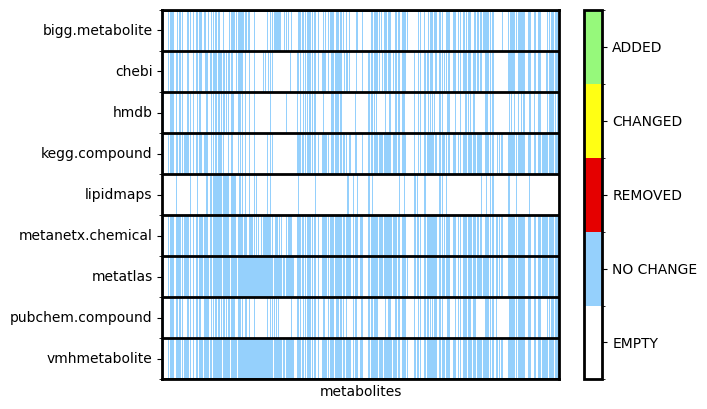

In [11]:
df_model = get_annotation_df(getattr(model, annotation_type), [mapping_key]).rename(
    {"id": annotation_type}, axis=1
)

df_annotations = get_annotations_HumanGEM(
    annotation_type, f"{database_dirpath}{HUMANGEM_PATH}"
)
df_annotations = df_annotations.rename({"mets": merge_key}, axis=1)
df_annotations = df_model.merge(
    df_annotations,
    left_on=mapping_key,
    right_on=merge_key if merge_key is not None else mapping_key,
    how="left",
)
if merge_key is not None and merge_key != mapping_key:
    df_annotations = df_annotations.drop(mapping_key, axis=1)

df_annotations = df_annotations.loc[:, [annotation_type] + annotation_columns]
if rename_miriam:
    df_annotations = df_annotations.rename(HUMANGEM_MIRIAM[annotation_type], axis=1)

if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{HUMANGEM_DB_TAG}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)

    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)

if display_nunique:
    df = df_annotations.copy()
    for col in df.columns:
        df[col] = df[col].apply(lambda x: split_string(x))
        df = df.explode(col).drop_duplicates()

    print(df.nunique())

if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{HUMANGEM_DB_TAG}.tsv", sep="\t"
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{HUMANGEM_DB_TAG}.tsv", sep="\t"
    )
df_annotations

## Genes

* `genes_Human-GEM.tsv` content:

|# |fieldname     |  annotation          |Prefixes (https://identifiers.org/)|
|--|--------------|----------------------|-----------------------------------|
|1 |genes         |Ensembl gene ID       |ensembl                            |
|2 |geneENSTID    |Ensembl transcript ID |ensembl                            |
|3 |geneENSPID    |Ensembl protein ID    |ensembl                            |
|4 |geneUniProtID |UniProt ID            |uniprot                            |
|5 |geneSymbols   |Gene Symbol           |hgnc.symbol                        |
|6 |geneEntrezID  |NCBI Entrez ID        |ncbigene                           |
|7 |geneNames     |Gene Name             |                                   |
|8 |geneAliases   |Alias Names           |                                   |
|9 |compartments  |Subcellular location  |                                   |
|10|compDataSource|Source for compartment|                                   |


##### Notes
* Unlike `reactions` and `metabolites`, the Human-GEM reconstruction does not have its own unique identifiers for genes but instead uses the 'Ensembl gene ID'. Therefore, slight alterations to the code are made to account for differences. 
* It is recommended to unify model with annotations using the NCBI Entrez ID or the UniProt ID.
* Include columns that link to https://identifiers.org/.
* For `ensembl`, the Ensembl gene ID is utilized for the annotation.

In [12]:
annotation_type = "genes"
mapping_key = "uniprot"
merge_key = "geneUniProtID"
rename_miriam = True
annotation_columns = HUMANGEM_MIRIAM[annotation_type].copy()
# Two mappings, only keep ensemble genes
del annotation_columns["geneENSTID"]
del annotation_columns["geneENSPID"]
annotation_columns = list(annotation_columns)

genes          718
ensembl        510
uniprot        510
hgnc.symbol    510
ncbigene       511
dtype: int64


,genes,ensembl,uniprot,hgnc.symbol,ncbigene
0,A4GALT,ENSG00000128274,Q9NPC4,A4GALT,53947
1,AARS1,ENSG00000090861,P49588,AARS1,16
2,AASDHPPT,ENSG00000149313,Q9NRN7,AASDHPPT,60496
3,ABCA1,ENSG00000165029,O95477,ABCA1,19
4,ABCA7,NaN,NaN,NaN,NaN
...,...,...,...,...,...
713,YARS1,ENSG00000134684,P54577,YARS1,8565
714,ZDHHC2,ENSG00000104219,Q9UIJ5,ZDHHC2,51201
715,ZDHHC20,ENSG00000180776,Q5W0Z9,ZDHHC20,253832
716,ZDHHC3,ENSG00000163812,Q9NYG2,ZDHHC3,51304


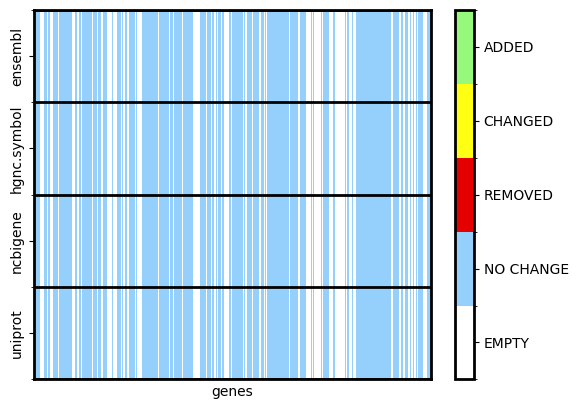

In [13]:
df_model = get_annotation_df(getattr(model, annotation_type), [mapping_key]).rename(
    {"id": annotation_type}, axis=1
)

df_annotations = get_annotations_HumanGEM(
    annotation_type, f"{database_dirpath}{HUMANGEM_PATH}"
)
df_annotations = df_annotations.rename({"genes": "geneEnsemblID"}, axis=1)
df_annotations = df_model.merge(
    df_annotations,
    left_on=mapping_key,
    right_on=merge_key if merge_key is not None else mapping_key,
    how="left",
)
if merge_key is not None and merge_key != mapping_key:
    df_annotations = df_annotations.drop(mapping_key, axis=1)

df_annotations = df_annotations.loc[:, [annotation_type] + annotation_columns]

if rename_miriam:
    df_annotations = df_annotations.rename(HUMANGEM_MIRIAM[annotation_type], axis=1)

if compare:
    try:
        df_previous = pd.read_csv(
            f"{annotation_dirpath}/{annotation_type}_{HUMANGEM_DB_TAG}.tsv",
            sep="\t",
            index_col=0,
            dtype=str,
        )
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=[annotation_type], dtype=str)

    df_comparision = compare_tables(
        df_previous.set_index(annotation_type),
        df_annotations.set_index(annotation_type),
    )
    ax = visualize_comparison(df_comparision)


if display_nunique:
    df = df_annotations.copy()
    for col in df.columns:
        df[col] = df[col].apply(lambda x: split_string(x))
        df = df.explode(col).drop_duplicates()

    print(df.nunique())


if overwrite:
    df_annotations.to_csv(
        f"{annotation_dirpath}/{annotation_type}_{HUMANGEM_DB_TAG}.tsv", sep="\t"
    )
else:
    df_annotations.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{annotation_type}_{HUMANGEM_DB_TAG}.tsv", sep="\t"
    )
df_annotations